In [19]:

import pandas as pd

# Load the Excel file to inspect the contents
file_path = 'budjet.xlsx'
excel_data = pd.ExcelFile(file_path)

# Display sheet names to understand the structure of the file
excel_data.sheet_names

# Load the data from the 'budjet' sheet
df = excel_data.parse('budjet')

# Display the first few rows to understand its structure
df.head()

# Save the cleaned dataset to a CSV file
csv_file_path = 'budget_data.csv'
df.to_csv(csv_file_path, index=False)


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Load your dataset (update the path accordingly if needed)
file_path = 'budjet.xlsx'
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 1: Data Preprocessing
# Convert the date into useful features
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop the original 'date' and 'category' columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 2: Splitting the Data into Training and Testing Sets
X = budjet_data_cleaned.drop(columns=['amount'])
y = budjet_data_cleaned['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define a dictionary of models to evaluate
models_dict = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(random_state=42)
}

# Step 4: Function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics

# Step 5: Train and evaluate each model, collecting all metrics
metrics_results = []

for model_name, model in models_dict.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate all metrics
    metrics = calculate_metrics(y_test, y_pred)
    
    # Append results to the list as a dictionary
    metrics_results.append({
        "Model": model_name,
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"],
        "RMSE": metrics["RMSE"],
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"]
    })

# Step 6: Convert the results list into a DataFrame
metrics_results_df = pd.DataFrame(metrics_results)

# Step 7: Display the results
metrics_results_df

,Model,MAE,MSE,RMSE,R2,MAPE
0,Random Forest,16.59,12154.99,110.25,-0.32,2.59
1,Decision Tree,18.43,16255.03,127.50,-0.77,2.27
2,Linear Regression,17.48,9208.34,95.96,-0.00,3.68
3,XGBoost,18.16,15025.66,122.58,-0.63,2.70


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import randint, uniform

# Load your dataset (update the path accordingly if needed)
file_path = 'budjet.xlsx'  # replace with your actual file path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 1: Data Preprocessing
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop the original 'date' and 'category' columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 2: Splitting the Data into Training and Testing Sets
X = budjet_data_cleaned.drop(columns=['amount'])
y = budjet_data_cleaned['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define a dictionary of models to evaluate and their hyperparameter grids

param_distributions = {
    "Random Forest": {
        'n_estimators': randint(10, 200),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 20),
    },
    "Decision Tree": {
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 20),
    },
    "XGBoost": {
        'n_estimators': randint(10, 200),
        'learning_rate': uniform(0.01, 0.5),
        'max_depth': randint(2, 20),
    }
}

models_dict = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Linear Regression has no hyperparameters to tune
models_dict["Linear Regression"] = LinearRegression()

# Step 4: Function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics

# Step 5: Hyperparameter tuning using RandomizedSearchCV
best_models = {}
for model_name, model in models_dict.items():
    if model_name in param_distributions:
        # Perform RandomizedSearchCV for models with hyperparameters
        random_search = RandomizedSearchCV(model, param_distributions[model_name], n_iter=20, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train)
        best_models[model_name] = random_search.best_estimator_
        print(f"Best parameters for {model_name}: {random_search.best_params_}")
    else:
        # No hyperparameters to tune for Linear Regression
        model.fit(X_train, y_train)
        best_models[model_name] = model

# Step 6: Train and evaluate each model, collecting all metrics
metrics_results = []

for model_name, model in best_models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate all metrics
    metrics = calculate_metrics(y_test, y_pred)
    
    # Append results to the list as a dictionary
    metrics_results.append({
        "Model": model_name,
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"],
        "RMSE": metrics["RMSE"],
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"]
    })

# Step 7: Convert the results list into a DataFrame
metrics_results_df = pd.DataFrame(metrics_results)

# Step 8: Display the results
print(metrics_results_df)


Best parameters for Random Forest: {'max_depth': 8, 'min_samples_split': 16, 'n_estimators': 116}
Best parameters for Decision Tree: {'max_depth': 8, 'min_samples_split': 12}
Best parameters for XGBoost: {'learning_rate': np.float64(0.1009124836035503), 'max_depth': 2, 'n_estimators': 67}
               Model   MAE      MSE   RMSE    R2  MAPE
0      Random Forest 13.76  8796.42  93.79  0.04  2.03
1      Decision Tree 16.08 10863.09 104.23 -0.18  2.32
2            XGBoost 14.68  8694.74  93.25  0.06  2.58
3  Linear Regression 17.48  9208.34  95.96 -0.00  3.68


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Load your dataset (update the path accordingly if needed)
file_path = 'budjet.xlsx'  # replace with your actual file path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 1: Data Preprocessing
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop the original 'date' and 'category' columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 2: Splitting the Data into Training and Testing Sets
X = budjet_data_cleaned.drop(columns=['amount'])
y = budjet_data_cleaned['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define parameter grids for Random Forest and XGBoost

# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [10, 16, 20],
}

# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [50, 67, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6]
}

# Step 4: GridSearchCV for hyperparameter tuning
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")

# Step 5: Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics

# Step 6: Evaluate the optimized models

# Predict with Random Forest
rf_y_pred = best_rf_model.predict(X_test)
rf_metrics = calculate_metrics(y_test, rf_y_pred)
print(f"Random Forest Performance: {rf_metrics}")

# Predict with XGBoost
xgb_y_pred = best_xgb_model.predict(X_test)
xgb_metrics = calculate_metrics(y_test, xgb_y_pred)
print(f"XGBoost Performance: {xgb_metrics}")

# Step 7: Combine the results into a DataFrame
metrics_results = pd.DataFrame([
    {"Model": "Random Forest", **rf_metrics},
    {"Model": "XGBoost", **xgb_metrics}
])

# Step 8: Display the results
print(metrics_results)


Best parameters for Random Forest: {'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 150}
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50}
Random Forest Performance: {'MAE': np.float64(13.765277950080094), 'MSE': np.float64(8687.114808753782), 'RMSE': np.float64(93.2046930618506), 'R2': 0.05612479232435996, 'MAPE': np.float64(2.011194809329284)}
XGBoost Performance: {'MAE': np.float64(15.256947376087432), 'MSE': np.float64(10316.201995660605), 'RMSE': np.float64(101.56870578904018), 'R2': -0.12087931556586207, 'MAPE': np.float64(2.287674207806325)}
           Model   MAE      MSE   RMSE    R2  MAPE
0  Random Forest 13.77  8687.11  93.20  0.06  2.01
1        XGBoost 15.26 10316.20 101.57 -0.12  2.29


In [18]:
# Step 2: Import necessary libraries
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Step 3: Load your dataset (update the path accordingly if needed)
file_path = 'budjet.xlsx'  # replace with your actual file path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 4: Data Preprocessing
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop the original 'date' and 'category' columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 5: Split the Data
X = budjet_data_cleaned.drop(columns=['amount'])
y = budjet_data_cleaned['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 6, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 30)

    # Create the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

# Step 7: Optimize the objective function using Optuna
study = optuna.create_study(direction='minimize')  # We want to minimize MAE
study.optimize(objective, n_trials=50)

# Step 8: Display the best parameters and performance
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Step 9: Train the model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Step 10: Evaluate the optimized model
y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Step 11: Display the results
metrics_results = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape
}
print("Optimized Random Forest Performance:", metrics_results)


Best hyperparameters: {'n_estimators': 105, 'max_depth': 9, 'min_samples_split': 13}
Optimized Random Forest Performance: {'MAE': np.float64(13.438903151765832), 'MSE': np.float64(8905.012597056158), 'RMSE': np.float64(94.36637429220303), 'R2': 0.03244969136003051, 'MAPE': np.float64(1.9638798562496125)}


In [17]:
# Step 2: Import necessary libraries
import optuna
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Step 3: Load your dataset (update the path accordingly if needed)
file_path = 'budjet.xlsx'  # replace with your actual file path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 4: Data Preprocessing
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop the original 'date' and 'category' columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 5: Remove Outliers Using IQR
Q1 = budjet_data_cleaned.quantile(0.25)
Q3 = budjet_data_cleaned.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers outside 1.5*IQR range
budjet_data_cleaned = budjet_data_cleaned[~((budjet_data_cleaned < (Q1 - 1.5 * IQR)) | (budjet_data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 6: Split the data into features (X) and target (y)
X = budjet_data_cleaned.drop(columns=['amount'])
y = budjet_data_cleaned['amount']

# Step 7: Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 6, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 30)

    # Create the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

# Step 9: Optimize the objective function using Optuna
study = optuna.create_study(direction='minimize')  # We want to minimize MAE
study.optimize(objective, n_trials=50)

# Step 10: Display the best parameters and performance
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Step 11: Train the model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Step 12: Evaluate the optimized model
y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Step 13: Display the results
metrics_results = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape
}
print("Optimized Random Forest Performance:", metrics_results)


Best hyperparameters: {'n_estimators': 172, 'max_depth': 11, 'min_samples_split': 29}
Optimized Random Forest Performance: {'MAE': np.float64(3.073095919018062), 'MSE': np.float64(17.003522049173636), 'RMSE': np.float64(4.123532714696664), 'R2': 0.16535618446837252, 'MAPE': np.float64(0.9409262117778985)}


Best hyperparameters: {'n_estimators': 185, 'max_depth': 10, 'min_samples_split': 22}
   MAE   MSE  RMSE   R2  MAPE
0 3.07 17.04  4.13 0.16  0.94


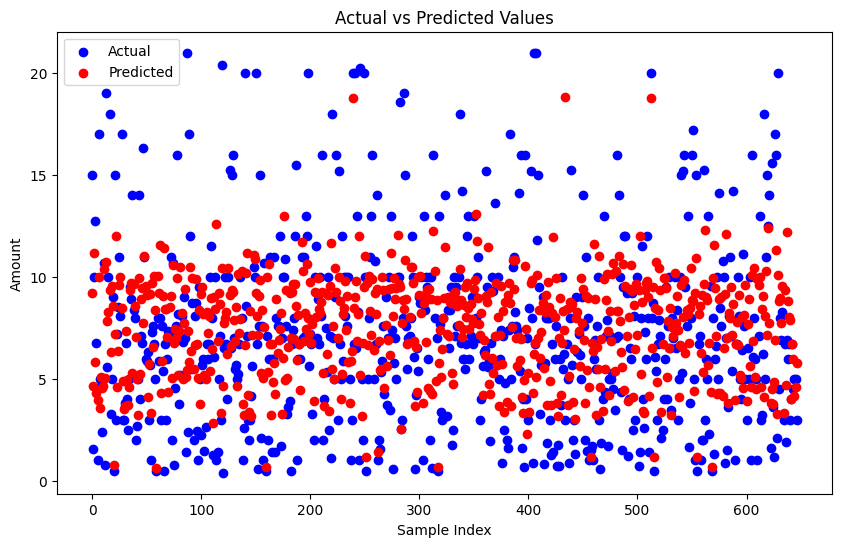

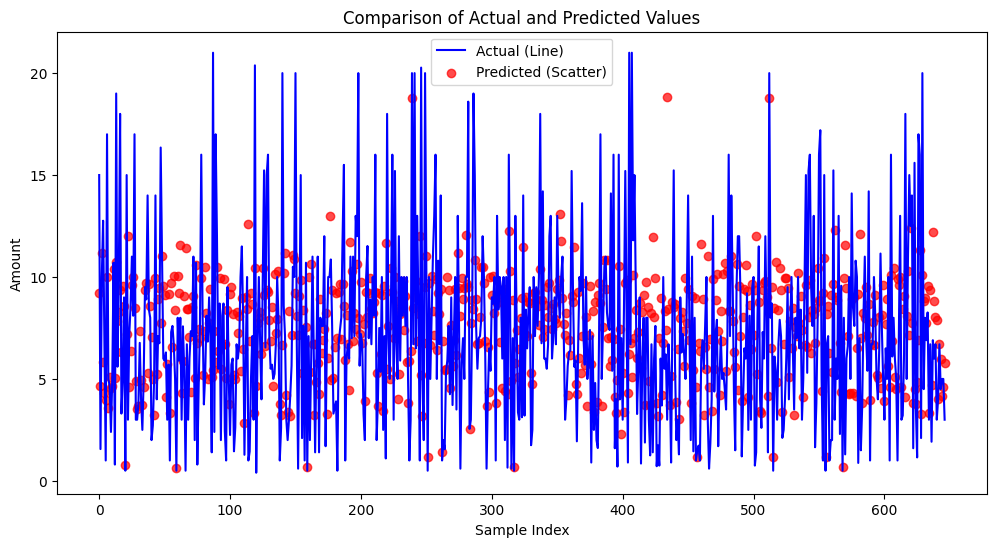

In [24]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import optuna
import optuna.logging

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Step 3: Load your dataset (update the path accordingly if needed)
file_path = 'budjet.xlsx'  # replace with your actual file path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 4: Data Preprocessing
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop the original 'date' and 'category' columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 5: Remove Outliers Using IQR
Q1 = budjet_data_cleaned.quantile(0.25)
Q3 = budjet_data_cleaned.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers outside 1.5*IQR range
budjet_data_cleaned = budjet_data_cleaned[~((budjet_data_cleaned < (Q1 - 1.5 * IQR)) | (budjet_data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 6: Split the data into features (X) and target (y)
X = budjet_data_cleaned.drop(columns=['amount'])
y = budjet_data_cleaned['amount']

# Step 7: Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 6, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 30)

    # Create the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

# Step 9: Optimize the objective function using Optuna
study = optuna.create_study(direction='minimize')  # We want to minimize MAE
study.optimize(objective, n_trials=50)

# Step 10: Get the best parameters
best_params = study.best_params

# Step 11: Train the model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Step 12: Evaluate the optimized model
y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Step 13: Store the results in a DataFrame
metrics_results = pd.DataFrame([{
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape
}])

# Step 14: Print the best hyperparameters and the results as a DataFrame
print(f"Best hyperparameters: {best_params}")
print(metrics_results)


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color="blue", label="Actual")
plt.scatter(range(len(y_pred)), y_pred, color="red", label="Predicted")
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Amount")
plt.legend()
plt.show()


# Create a figure
plt.figure(figsize=(12, 6))

# Plot actual values as a line
plt.plot(range(len(y_test)), y_test, color="blue", label="Actual (Line)")

# Plot predicted values as a scatter plot
plt.scatter(range(len(y_pred)), y_pred, color="red", label="Predicted (Scatter)", alpha=0.7)

# Add titles and labels
plt.title("Comparison of Actual and Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Amount")

# Show legend
plt.legend()

# Display the plot
plt.show()



In [2]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib  # For saving and loading models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import optuna
import optuna.logging

import warnings
warnings.filterwarnings("ignore")

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Step 3: Load your dataset
file_path = 'budjet.xlsx'  # update this with actual path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 4: Data Preprocessing
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month

# Encode the 'category' column using LabelEncoder
label_encoder = LabelEncoder()
budjet_data['category_encoded'] = label_encoder.fit_transform(budjet_data['category'])

# Drop unnecessary columns
budjet_data_cleaned = budjet_data.drop(columns=['date', 'category'])

# Step 5: Remove Outliers Using IQR
Q1 = budjet_data_cleaned.quantile(0.25)
Q3 = budjet_data_cleaned.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers outside 1.5*IQR range
budjet_data_cleaned = budjet_data_cleaned[~((budjet_data_cleaned < (Q1 - 1.5 * IQR)) | 
                                           (budjet_data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 6: Prepare features (X) and target (y)
X = budjet_data_cleaned[['year', 'month', 'category_encoded']]
y = budjet_data_cleaned['amount']

# Step 7: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 6, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 30)

    # Create RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict and calculate MAE
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

# Step 9: Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Step 10: Get best hyperparameters and train the model
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Step 11: Save the model, scaler, and label encoder using joblib
joblib.dump(best_rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model, Scaler, and Label Encoder saved as pkl files.")

# Step 12: Function to predict expenses for each category after loading the model
def load_and_predict_expenses(year, month):
    # Load the model and related objects
    loaded_model = joblib.load('rf_model.pkl')
    loaded_scaler = joblib.load('scaler.pkl')
    loaded_label_encoder = joblib.load('label_encoder.pkl')
    
    categories = loaded_label_encoder.classes_
    predictions = {}
    
    for category in categories:
        category_encoded = loaded_label_encoder.transform([category])[0]
        input_data = np.array([[year, month, category_encoded]])
        input_scaled = loaded_scaler.transform(input_data)
        predicted_amount = loaded_model.predict(input_scaled)
        predictions[category] = predicted_amount[0]
    
    return predictions

# Example usage: Predict expenses for November 2024 after loading the model
predicted_expenses_nov_2024 = load_and_predict_expenses(2024, 11)
print(predicted_expenses_nov_2024)

# Step 13: Evaluate the optimized model
y_pred = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Step 14: Store results in DataFrame
metrics_results = pd.DataFrame([{
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape
}])

# Print the best hyperparameters and results
print(f"Best hyperparameters: {best_params}")
print(metrics_results)


Model, Scaler, and Label Encoder saved as pkl files.
{'Business lunch': np.float64(9.40161399381735), 'Clothing': np.float64(8.98756318473304), 'Coffe': np.float64(9.699711851292754), 'Communal': np.float64(9.720332568771118), 'Events': np.float64(11.341262899158684), 'Film/enjoyment': np.float64(11.314663220592498), 'Fuel': np.float64(12.045905446277871), 'Health': np.float64(6.927383061742303), 'Learning': np.float64(10.631227367416196), 'Market': np.float64(8.195556212268384), 'Motel': np.float64(9.288673874152966), 'Other': np.float64(9.288673874152966), 'Phone': np.float64(7.5423733076939685), 'Rent Car': np.float64(9.185147342159576), 'Restuarant': np.float64(8.792298622589305), 'Sport': np.float64(18.757882234836764), 'Taxi': np.float64(3.5294137685648788), 'Tech': np.float64(3.5386247009885308), 'Transport': np.float64(1.2453097676757765), 'Travel': np.float64(6.686018692030305), 'business_expenses': np.float64(9.261170994334831), 'joy': np.float64(9.815101229346814)}
Best hype

In [5]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import optuna
import optuna.logging
import warnings
import calendar

warnings.filterwarnings("ignore")

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Step 3: Load your dataset
file_path = 'budjet.xlsx'  # Update this with the actual path
budjet_data = pd.read_excel(file_path, sheet_name='budjet')

# Step 4: Data Preprocessing (Updated with Dummy Encoding)
budjet_data['date'] = pd.to_datetime(budjet_data['date'])
budjet_data['year'] = budjet_data['date'].dt.year
budjet_data['month'] = budjet_data['date'].dt.month
budjet_data['day'] = budjet_data['date'].dt.day
budjet_data['day_of_week'] = budjet_data['date'].dt.dayofweek

# Apply dummy encoding for 'category' column
budjet_data_dummies = pd.get_dummies(budjet_data, columns=['category'], drop_first=True)

# Step 5: Add scaling to the target variable (amount)
scaler_target = MinMaxScaler()  # Use MinMaxScaler to ensure target scaling reflects real-world values
budjet_data_dummies['amount_scaled'] = scaler_target.fit_transform(budjet_data_dummies[['amount']])

# Drop unnecessary columns
budjet_data_cleaned = budjet_data_dummies.drop(columns=['date', 'amount'])

# Step 6: Remove Outliers Using IQR (only for numeric columns)
numeric_cols = ['year', 'month', 'day', 'day_of_week']  # Columns with numeric data
Q1 = budjet_data_cleaned[numeric_cols].quantile(0.25)
Q3 = budjet_data_cleaned[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers outside 1.5*IQR range (only for numeric columns)
budjet_data_cleaned = budjet_data_cleaned[~((budjet_data_cleaned[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                                           (budjet_data_cleaned[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 7: Prepare features (X) and scaled target (y)
X = budjet_data_cleaned.drop(columns=['amount_scaled'])
y = budjet_data_cleaned['amount_scaled']  # Use the scaled amount

# Step 8: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 9: Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 6, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 30)

    # Create RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict and calculate MAE
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

# Step 10: Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Step 11: Get best hyperparameters and train the model
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Step 12: Save the model, scaler, target scaler, and feature columns using joblib
joblib.dump(best_rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')  # Save the target scaler
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')  # Save feature columns

print("Model, Scaler, Target Scaler, and Feature Columns saved as pkl files.")

# Step 13: Function to predict expenses for each category after loading the model
def load_and_predict_expenses(year, month):
    # Load the model and related objects
    loaded_model = joblib.load('rf_model.pkl')
    loaded_scaler = joblib.load('scaler.pkl')
    loaded_scaler_target = joblib.load('scaler_target.pkl')  # Load the target scaler
    feature_columns = joblib.load('feature_columns.pkl')  # Load the feature columns used during training
    
    # Get the number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    
    # Get the dummy-encoded columns for the categories
    categories = [col for col in feature_columns if 'category_' in col]
    daily_predictions = {}
    total_monthly_expense = 0
    
    # Iterate over each category
    for category in categories:
        # Create a DataFrame to hold input data for all days in the month
        input_df = pd.DataFrame(0, index=range(num_days), columns=feature_columns)
        
        # Set the numeric columns
        input_df['year'] = year
        input_df['month'] = month
        input_df['day'] = range(1, num_days+1)
        input_df['day_of_week'] = [calendar.weekday(year, month, day) for day in input_df['day']]
        
        # Set the category column to 1
        input_df[category] = 1
        
        # Scale the input data
        input_scaled = loaded_scaler.transform(input_df)
        
        # Predict
        predicted_amount_scaled = loaded_model.predict(input_scaled)
        
        # Inverse transform the predicted scaled amount back to original scale using the target scaler
        predicted_amount = loaded_scaler_target.inverse_transform(predicted_amount_scaled.reshape(-1, 1)).reshape(-1)
        
        # Sum up the predicted amounts for the category
        category_total = predicted_amount.sum()
        
        # Store the total for the category
        daily_predictions[category] = category_total
        total_monthly_expense += category_total
        
        # No need to reset the category column as we're recreating input_df for each category
    
    # Return both per-category totals and the overall monthly total
    return {
        'category_wise_predictions': daily_predictions,
        'total_monthly_expense': total_monthly_expense
    }

# Example usage: Predict expenses for November 2024 after loading the model
predicted_expenses_nov_2024 = load_and_predict_expenses(2024, 11)
print(predicted_expenses_nov_2024)

# Step 14: Evaluate the optimized model
y_pred_scaled = best_rf_model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1)  # Inverse transform predictions
y_test_actual = scaler_target.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)  # Inverse transform true values

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)

# Step 15: Store results in DataFrame
metrics_results = pd.DataFrame([{
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2,
    "MAPE": mape
}])

# Print the best hyperparameters and results
print(f"Best hyperparameters: {best_params}")
print(metrics_results)


Model, Scaler, Target Scaler, and Feature Columns saved as pkl files.
{'category_wise_predictions': {'category_Clothing': np.float64(3315.945950930893), 'category_Coffe': np.float64(240.27537359436815), 'category_Communal': np.float64(3920.3571467462743), 'category_Events': np.float64(1912.5117461942496), 'category_Film/enjoyment': np.float64(234.23804034167821), 'category_Fuel': np.float64(234.23804034167821), 'category_Health': np.float64(4502.587043399415), 'category_Learning': np.float64(1016.1951360829316), 'category_Market': np.float64(229.51178468455078), 'category_Motel': np.float64(12815.084905913127), 'category_Other': np.float64(306.40307145998537), 'category_Phone': np.float64(234.23804034167821), 'category_Rent Car': np.float64(234.23804034167821), 'category_Restuarant': np.float64(832.0485340359875), 'category_Sport': np.float64(1746.8147368948114), 'category_Taxi': np.float64(225.80531595820653), 'category_Tech': np.float64(10347.1919774429), 'category_Transport': np.flo